## Biblioteki

In [ ]:
%pip install numpy matplotlib deap pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
from deap import tools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import itertools
import math
import random
import warnings

# Optymalizacja przecięć grafów

## Problem

Na wejściu zadany jest graf, w postaci listy wierzchołków oraz krawędzi.\
Na wyjściu należy narysować, graf tak, aby zminimalizować liczbę przecięć krawędzi.

## Propozycja algorytmu

### Fenotyp

Wszystkie wierzchołki grafu rozłożone są na osi X w pewnej kolejności. \
Krawędzie pomiędzy nimi są rysowane jako elipsy nad lub pod osią.

Przykład:

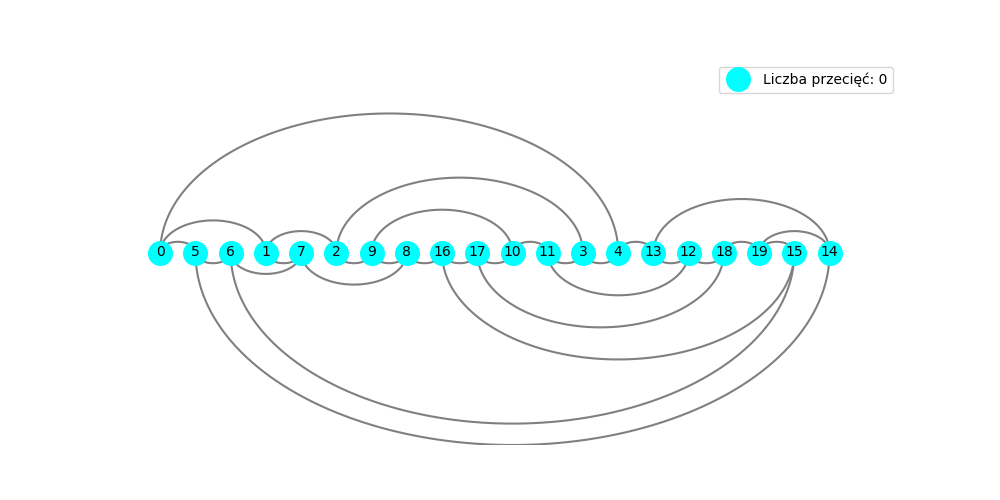


In [ ]:
# funkcja wizualizująca
def visualize_krzywe(n_verts, edges, solution):
    '''
    n_verts - liczba wierzchołków grafu
    edges - lista krawędzi grafu
    solution - wynik algorytmu ewolucyjnego
    '''

    order, pages = solution
    rev_order = np.zeros(n_verts, dtype=int)

    _, ax = plt.subplots(figsize=(10, 5))
    for (i, vert) in enumerate(order):
        rev_order[vert] = i
        ax.plot(i, 0, 'o', markersize=17, color='cyan', zorder=2)
        ax.text(i, 0, f'{vert+1}', fontsize=10, ha='center', va='center', zorder=3)

    max_radius = 0
    total_crossings = 0

    other_edges = []
    for i, e in enumerate(edges):
        x1 = rev_order[e[0]]
        x2 = rev_order[e[1]]
        mid_x = (x1 + x2) / 2
        radius = abs(x2 - x1) / 2

        theta = np.linspace(0, np.pi, 100)
        max_radius = max(max_radius, radius)
        arc_x = mid_x + radius * np.cos(theta)
        arc_y = radius * np.sin(theta)

        for other_i, (other_mid, other_r) in enumerate(other_edges):
            if(pages[i] != pages[other_i]):
                continue

            if abs(mid_x - other_mid) < 0.1:
                continue

            x = (mid_x**2 - other_mid**2 - radius**2 + other_r**2) / (2*(mid_x - other_mid))
            y = radius**2 - (x - mid_x)**2
            if y <= 0:
                continue

            total_crossings += 1
            plt.plot(x, pages[i]*np.sqrt(y), 'o', markersize=5, color='red', zorder=5)

        other_edges.append((mid_x, radius))
        plt.plot(arc_x, pages[i]*arc_y, color='gray', zorder=1)

    plt.xlim(-1, n_verts+1)
    plt.ylim(-max_radius, max_radius)

    plt.legend([f'Liczba przecięć: {total_crossings}'])
    plt.axis('off')
    plt.show()

### Genotyp

Dany osobnik składa się z permutacji wierzchołków grafu oraz przypisania stron (góra lub dół) dla każdej krawędzi.

### Inicjalizacja populacji

Początkowa populacja jest generowana przy użyciu algorytmu DFS. W celu zróźnicowania populacji wybierany jest losowy punkt startowy, oraz kolejność doboru krawędzi jest losowa. Strony rysowania krawędzi są losowe.

In [ ]:
def dfs_ordering(vertices, edges):
    """
    Kolejność wierzchołków uzyskana algorytmem DFS.

    Args:
        vertices (list): Lista wierzchołków grafu.
        edges (list): Lista krawędzi w postaci (u, v).

    Returns:
        list: Kolejność wierzchołków.
    """
    visited = {v: False for v in vertices}
    order = []

    vertices_shuffled = random.sample(vertices, len(vertices))
    edges_shuffled = random.sample(edges, len(edges))

    def dfs(v):
        visited[v] = True
        for u, w in edges_shuffled:
            if u == v and not visited[w]:
                dfs(w)
        order.append(v)

    for v in vertices_shuffled:
        if not visited[v]:
            dfs(v)

    return order[::-1]

def dfs_individual(vertices, edges):
    """
    Generuje osobnik dla algorytmu ewolucyjnego. Permutacja + strony krawędzi
    """
    return dfs_ordering(vertices, edges), [((u, v), random.randint(0, 1)) for u, v in edges]

### Funkcja dopasowania

Jako fitness przyjmujemy liczbę przecięć wszystkich krawędzi.\
Krawędzie są grupowane na strony i dla każdej pary krawędzi w grupie sprawdzany jest warunek:

$ \text{p}_1 < \text{p}_2 < \text{k}_1 < \text{k}_2 $

gdzie:
 - p - współrzędna wierchołka początkowego
 - k - współrzędna wierchołka końcowego

Spełnienie tego warunku oznacza, że się one przecinają. Następnie sumowana jest liczba wszystkich przecięć.

In [ ]:
# Edge Recombination Crossover
def edge_recombination(parent1, parent2):
    """
    Edge Recombination Crossover for generating offspring from two parents.

    Args:
        parent1 (list): First parent, a permutation of vertices.
        parent2 (list): Second parent, a permutation of vertices.

    Returns:
        list: Child, a permutation of vertices.
    """
    edges = {v: set() for v in parent1}
    size = len(parent1)

    for p in [parent1, parent2]:
        for i in range(size):
            edges[p[i]].add(p[(i - 1) % size])
            edges[p[i]].add(p[(i + 1) % size])

    current = parent1[0]
    child = [current]

    while len(child) < size:
        for neighbor in edges.values():
            neighbor.discard(current)

        if edges[current]:
            current = min(edges[current], key=lambda x: len(edges[x]))
        else:
            remaining = set(parent1) - set(child)
            current = random.choice(list(remaining))

        child.append(current)

    return child


In [ ]:
def count_edge_crossings(vertices, edges_page):
    position = {v: i for i, v in enumerate(vertices)}
    crossings = 0

    edges_top = [edge for edge, page in edges_page if page == 0]
    edges_bottom = [edge for edge, page in edges_page if page == 1]

    def count_crossings_on_page(edges):
        count = 0
        for i in range(len(edges)):
            for j in range(i + 1, len(edges)):
                u1, v1 = edges[i]
                u2, v2 = edges[j]

                u1_pos, v1_pos = position[u1], position[v1]
                u2_pos, v2_pos = position[u2], position[v2]

                if u1_pos > v1_pos:
                    u1_pos, v1_pos = v1_pos, u1_pos
                if u2_pos > v2_pos:
                    u2_pos, v2_pos = v2_pos, u2_pos

                if (u1_pos < u2_pos < v1_pos < v2_pos) or (u2_pos < u1_pos < v2_pos < v1_pos):
                    count += 1
        return count

    crossings += count_crossings_on_page(edges_top)
    crossings += count_crossings_on_page(edges_bottom)

    return crossings


### Rekombinacja

Krzyżowanie permutacji wierzchołków realizowane jest przy użyciu algorytmu PMX (Partially Matched Crossover), który zapewnia zachowanie poprawności permutacji. Dodatkowo przypisania stron krawędzi są mieszane jednorodnie z użyciem przypisań rodziców.

In [ ]:
def edge_recombination(parent1, parent2):

    # Tworzenie mapy krawędzi dla obu rodziców
    edges = {v: set() for v in parent1}
    size = len(parent1)

    for parent in [parent1, parent2]:
        for i in range(size):
            edges[parent[i]].add(parent[(i - 1) % size])  # poprzedni wierzchołek
            edges[parent[i]].add(parent[(i + 1) % size])  # następny wierzchołek

    # Wybór początkowego wierzchołka (pierwszy w parent1)
    current = parent1[0]
    child = [current]

    while len(child) < size:
        # Usuń bieżący wierzchołek z list krawędzi
        for neighbors in edges.values():
            neighbors.discard(current)

        # Wybierz sąsiada z najmniejszą liczbą krawędzi
        if edges[current]:
            current = min(edges[current], key=lambda x: len(edges[x]))
        else:
            # Jeśli brak sąsiadów, wybierz losowy z pozostałych wierzchołków
            remaining = set(parent1) - set(child)
            current = random.choice(list(remaining))

        # Dodaj wybrany wierzchołek do dziecka
        child.append(current)

    return child


### Mutacja

Mtacja permutacji wierzchołków polega na zamianie miejscami dwóch losowych wierzchołków lub więcej, natomiast mutacja przypisań stron krawędzi zmienia stronę (góra/dół) z zadanym prawdopodobieństwem.

In [ ]:
def mutate_harder(individual, mutation_rate=0.1):
    vertex_order, edges_page = individual

    # Mutacja permutacji wierzchołków
    for i in range(len(vertex_order)):
        if random.random() < mutation_rate:
            j = np.random.randint(0, len(vertex_order))
            vertex_order[i], vertex_order[j] = vertex_order[j], vertex_order[i]

    # Mutacja przypisania stron krawędzi
    for k in range(len(edges_page)):
        if random.random() < mutation_rate:
            edge, page = edges_page[k]
            edges_page[k] = (edge, 1 - page)  # Zmień stronę

    return vertex_order, edges_page

### Selekcja

50% osobników o najlepszej wartości funkcji dopasowania pozostaje w puli, a następnie do momentu uzyskania oczekiwanego rozumioru populacji losowe osobniki z pozostałych są mnożone między sobą.

### Warunek stopu

Algorytm jest wykonywany przez zadaną liczbę generacji (250) lub do znalezienia grafu bez żadnych przecięć.

### Końcowy algorytm ewolucyjny

In [ ]:
def evolutionary_algorithm2(vertices, edges, stats=None, population_size=125, generations=300, mutation_rate=0.05, quiet=False):
    evaluation_count = 0

    # Inicjalizacja populacji
    population = [dfs_individual(vertices, edges) for _ in range(population_size)]

    for generation in range(generations):
        # Ocena populacji
        fitness = []
        for ind in population:
            fitness_value = count_edge_crossings(ind[0], ind[1])
            fitness.append(fitness_value)
            evaluation_count += 1

        sorted_population = sorted(zip(population, fitness), key=lambda x: x[1])
        population = [ind for ind, _ in sorted_population]

        # Wypisz wynik dla obecnej generacji
        best_fitness = sorted_population[0][1]
        worst_fitness = sorted_population[-1][1]
        avg_fitness = sum(fitness) / len(fitness)

        if stats is not None:
            stats.append((best_fitness, avg_fitness, worst_fitness))

        if not quiet:
            print(f"Generacja {generation + 1}: min = {best_fitness}, avg = {avg_fitness}, max = {worst_fitness}, Ewaluacje = {evaluation_count}")

        if abs(best_fitness) < 0.1:
            break

        # Selekcja rodziców
        parents = population[:population_size // 2]

        # Tworzenie nowej populacji
        new_population = parents[:]
        while len(new_population) < population_size:
          parent1, parent2 = random.sample(parents, 2)
          child1 = edge_recombination(parent1[0], parent2[0])  # Edge Recombination
          child1_edges = [(edge, random.randint(0, 1)) for edge, _ in parent1[1]]
          new_population.append(mutate_harder((child1, child1_edges), mutation_rate))



        population = new_population

    # Zwróć najlepsze rozwiązanie
    best_solution = min(population, key=lambda ind: count_edge_crossings(ind[0], ind[1]))
    return best_solution, best_fitness, evaluation_count

## Statystyki działania algorytmu

### Grafy testowe

Do liczenia statystyk zostały wykorzystane następujące grafy

[Dodecahedron](https://en.wikipedia.org/wiki/Planar_graph) (0 przecięć)              |  [K 4,7](https://en.wikipedia.org/wiki/Tur%C3%A1n%27s_brick_factory_problem) (18 przecięć)
:-------------------------:|:-------------------------:
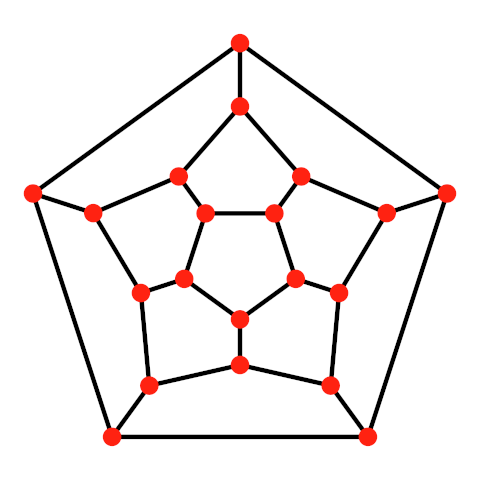  |  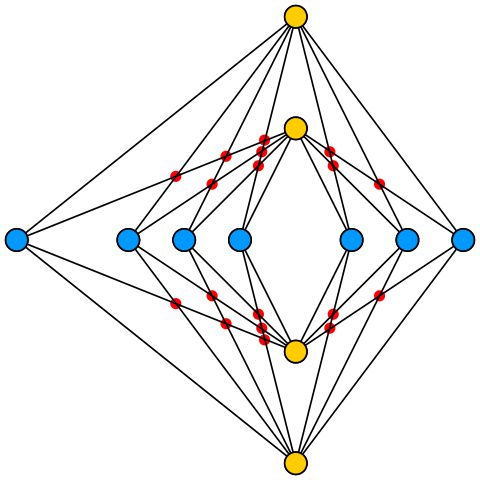

In [ ]:
# Dodecahedron
graf1 = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [[6, 15], [17, 10], [2, 3], [11, 12], [19, 14], [13, 14], [0, 1], [6, 7], [0, 5], [8, 7], [18, 12], [17, 18], [10, 11], [8, 16], [9, 2], [3, 4], [1, 7], [9, 10], [1, 2], [4, 13], [5, 14], [8, 9], [16, 17], [19, 15], [0, 4], [16, 15], [5, 6], [18, 19], [12, 13], [11, 3]])

# K 4,7
graf2 = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [[8, 2], [1, 4], [9, 3], [3, 7], [0, 10], [2, 6], [3, 6], [0, 5], [8, 3], [1, 5], [0, 7], [1, 10], [2, 7], [9, 2], [0, 8], [0, 9], [3, 4], [1, 9], [0, 6], [1, 7], [2, 10], [2, 5], [10, 3], [0, 4], [2, 4], [8, 1], [3, 5], [1, 6]])

### Przykład działania

In [ ]:
def test_algo(graf):
    vertices, edges = graf

    # Uruchom algorytm ewolucyjny
    (best_vertices, best_edges_page), fit, evals = evolutionary_algorithm2(vertices, edges, quiet=True)
    edges2 = [(u-1, v-1) for (u, v) in edges]
    verts = [v-1 for v in best_vertices]
    pages_diff = [page*2-1 for _, page in best_edges_page]

    print(f"Najlepszy układ wierzchołków: {best_vertices}")
    print(f"Najlepsze przypisanie stron krawędzi: {best_edges_page}")
    print(f"Liczba przecięć: {fit}")
    print(f"Liczba ewaluacji: {evals}")
    visualize_krzywe(len(verts), edges2, (verts, pages_diff))

Najlepszy układ wierzchołków: [0, 1, 2, 10, 9, 17, 16, 8, 7, 6, 15, 5, 14, 13, 19, 18, 12, 11, 3, 4]
Najlepsze przypisanie stron krawędzi: [((6, 15), 0), ((17, 10), 0), ((2, 3), 0), ((11, 12), 0), ((19, 14), 1), ((13, 14), 1), ((0, 1), 1), ((6, 7), 1), ((0, 5), 1), ((8, 7), 1), ((18, 12), 1), ((17, 18), 0), ((10, 11), 0), ((8, 16), 1), ((9, 2), 1), ((3, 4), 0), ((1, 7), 1), ((9, 10), 1), ((1, 2), 1), ((4, 13), 1), ((5, 14), 1), ((8, 9), 1), ((16, 17), 0), ((19, 15), 0), ((0, 4), 0), ((16, 15), 0), ((5, 6), 1), ((18, 19), 0), ((12, 13), 1), ((11, 3), 0)]
Liczba przecięć: 2
Liczba ewaluacji: 37500


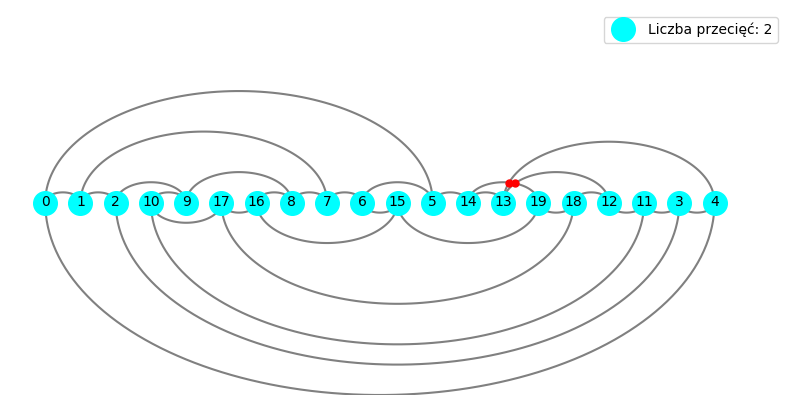

In [ ]:
test_algo(graf1)

Najlepszy układ wierzchołków: [0, 7, 10, 9, 2, 5, 3, 4, 8, 1, 6]
Najlepsze przypisanie stron krawędzi: [((8, 2), 0), ((1, 4), 0), ((9, 3), 1), ((3, 7), 1), ((0, 10), 0), ((2, 6), 0), ((3, 6), 1), ((0, 5), 1), ((8, 3), 1), ((1, 5), 0), ((0, 7), 0), ((1, 10), 0), ((2, 7), 1), ((9, 2), 1), ((0, 8), 1), ((0, 9), 0), ((3, 4), 1), ((1, 9), 0), ((0, 6), 0), ((1, 7), 0), ((2, 10), 0), ((2, 5), 1), ((10, 3), 1), ((0, 4), 1), ((2, 4), 0), ((8, 1), 0), ((3, 5), 1), ((1, 6), 0)]
Liczba przecięć: 19
Liczba ewaluacji: 37500


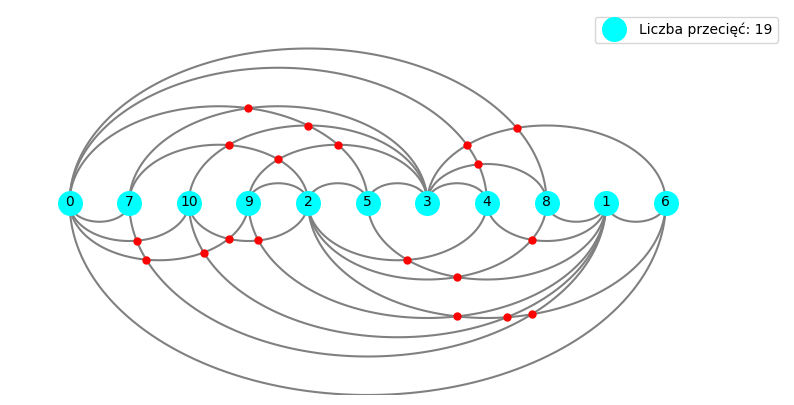

In [ ]:
test_algo(graf2)

### Efektywność / Wydajność

In [ ]:
def stats(graf, algo, actual_minimum=None):
    warnings.filterwarnings("ignore")
    vertices, edges = graf

    results = []
    for i in tqdm(range(100)):
        # Uruchom algorytm ewolucyjny
        _, fitness, evals = algo(vertices, edges, quiet=True)
        results.append([fitness, evals])

    df = pd.DataFrame(results, columns=['Przecięcia', 'Wyliczenia fitness'])
    crossings = df['Przecięcia']
    print(f'success_rate: { crossings.value_counts().get(actual_minimum, 0) / df.shape[0] * 100 } %')
    print()

    display(df.describe())
    print()

In [ ]:
print('Graf 1 - 0 przecięć \n')
stats(graf1, evolutionary_algorithm2, actual_minimum=0)

Graf 1 - 0 przecięć 



  0%|          | 0/100 [00:00<?, ?it/s]

success_rate: 98.0 %



,Przecięcia,Wyliczenia fitness
count,100.000000,100.000000
mean,0.090000,13968.620000
std,0.726066,6068.003227
min,0.000000,5669.000000
25%,0.000000,10457.000000
50%,0.000000,12347.000000
75%,0.000000,15906.500000
max,7.000000,37799.000000


In [ ]:
print('Graf 2 - 18 przecięć \n')
stats(graf2, evolutionary_algorithm2, actual_minimum=18)

Graf 2 - 18 przecięć 



  0%|          | 0/100 [00:00<?, ?it/s]

success_rate: 100.0 %



,Przecięcia,Wyliczenia fitness
count,100.0,100.0
mean,18.0,37799.0
std,0.0,0.0
min,18.0,37799.0
25%,18.0,37799.0
50%,18.0,37799.0
75%,18.0,37799.0
max,18.0,37799.0


### Średni fitness w zależności od generacji

In [ ]:
def graph_fitness(gname, graph):
  for i in tqdm(range(25)):
      stats = []
      _, fitness, evals = evolutionary_algorithm2(graph[0], graph[1], quiet=True, stats=stats)
      plt.plot(np.arange(len(stats)), np.swapaxes(np.array(stats), 0, 1)[1])

  plt.title('Średnia liczba przecięć w zależności od generacji - ' + gname)
  plt.xlabel('Generacja')
  plt.ylabel('Średnia wartość fitness w populacji')
  plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

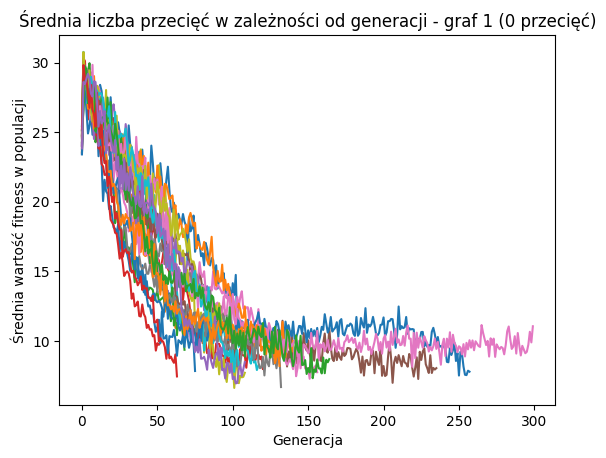

In [ ]:
graph_fitness('graf 1 (0 przecięć)', graf1)

  0%|          | 0/25 [00:00<?, ?it/s]

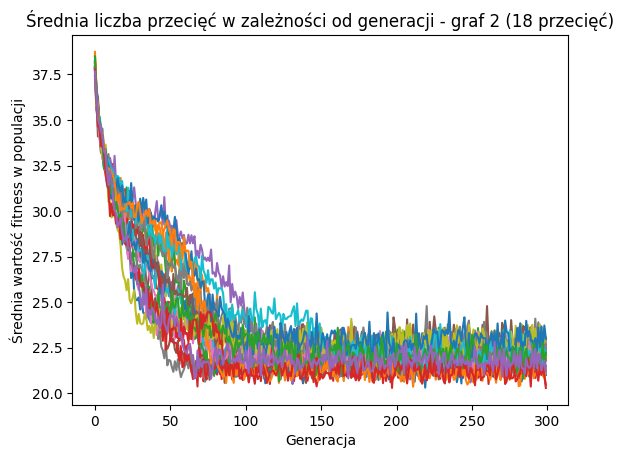

In [ ]:
graph_fitness('graf 2 (18 przecięć)', graf2)